In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
import random
import matplotlib.pyplot as plt
import numpy as np
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(15),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                       ])


In [3]:
train = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)
test = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:13<00:00, 12684353.53it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


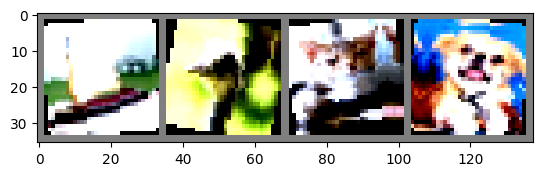

ship  bird  cat   dog  


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [6]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # CONVOLUTION BLOCK 1 input 32/1/1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 32/3


        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 32/5

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 32/5
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 16/6/2

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 16/10/2

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 16/14/2

        # TRANSITION BLOCK 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 16/14/2
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 8/16/4

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 8/24/4
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 6/32/4

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 4/40/4

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        )


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = x + self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = x + self.convblock5(x)
        x = self.convblock6(x)
        x = self.pool1(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.gap(x)
        x = self.convblock10(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]             512
        MaxPool2d-10           [-1, 16, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           4,608
             ReLU-12           [-1, 32, 16, 16]               0
      BatchNorm2d-13           [-1, 32, 16, 16]              64
          Dropout-14           [-1

In [47]:
from tqdm import tqdm

train_losses = []
train_loss_per_epoc = []
train_acc_per_epoc = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  train_loss = 0
  train_accuracy_value = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)
    train_loss += loss


    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
    train_accuracy_value += 100*correct/processed

  train_loss_per_epoc.append(train_loss/len(train_loader))
  train_acc_per_epoc.append(train_accuracy_value/len(train_loader))

def test(model, device, test_loader):
    wrongly_predicted_samples = {}
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            # storing the misclassified samples
            misclassified_index = torch.nonzero(target != pred.squeeze(1)).squeeze()
            if wrongly_predicted_samples == {}:
              wrongly_predicted_samples = {
                  "image" : data[misclassified_index],
                  "target" : target[misclassified_index],
                  "pred" : pred.squeeze(1)[misclassified_index]
              }
            else:
              wrongly_predicted_samples["image"] = torch.cat([wrongly_predicted_samples["image"], data[misclassified_index]], dim = 0)
              wrongly_predicted_samples["target"] = torch.cat([wrongly_predicted_samples["target"], target[misclassified_index]], dim = 0)
              wrongly_predicted_samples["pred"] = torch.cat([wrongly_predicted_samples["pred"], pred.squeeze(1)[misclassified_index] ], dim = 0)

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))
    return wrongly_predicted_samples

In [48]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.6041628122329712 Batch_id=97 Accuracy=34.29: 100%|██████████| 98/98 [00:30<00:00,  3.21it/s]



Test set: Average loss: 1.5810, Accuracy: 4084/10000 (40.84%)

EPOCH: 1


Loss=1.3058042526245117 Batch_id=97 Accuracy=47.16: 100%|██████████| 98/98 [00:29<00:00,  3.33it/s]



Test set: Average loss: 1.3140, Accuracy: 5188/10000 (51.88%)

EPOCH: 2


Loss=1.1812702417373657 Batch_id=97 Accuracy=52.55: 100%|██████████| 98/98 [00:30<00:00,  3.18it/s]



Test set: Average loss: 1.2816, Accuracy: 5307/10000 (53.07%)

EPOCH: 3


Loss=1.2235265970230103 Batch_id=97 Accuracy=56.15: 100%|██████████| 98/98 [00:29<00:00,  3.32it/s]



Test set: Average loss: 1.1742, Accuracy: 5709/10000 (57.09%)

EPOCH: 4


Loss=1.104864239692688 Batch_id=97 Accuracy=58.16: 100%|██████████| 98/98 [00:29<00:00,  3.27it/s]



Test set: Average loss: 1.1560, Accuracy: 5880/10000 (58.80%)

EPOCH: 5


Loss=1.0882527828216553 Batch_id=97 Accuracy=60.25: 100%|██████████| 98/98 [00:30<00:00,  3.21it/s]



Test set: Average loss: 1.0348, Accuracy: 6231/10000 (62.31%)

EPOCH: 6


Loss=0.9928452372550964 Batch_id=97 Accuracy=61.34: 100%|██████████| 98/98 [00:29<00:00,  3.28it/s]



Test set: Average loss: 0.9827, Accuracy: 6435/10000 (64.35%)

EPOCH: 7


Loss=1.0599373579025269 Batch_id=97 Accuracy=63.16: 100%|██████████| 98/98 [00:30<00:00,  3.19it/s]



Test set: Average loss: 0.9524, Accuracy: 6633/10000 (66.33%)

EPOCH: 8


Loss=1.1911059617996216 Batch_id=97 Accuracy=64.47: 100%|██████████| 98/98 [00:30<00:00,  3.26it/s]



Test set: Average loss: 0.9495, Accuracy: 6581/10000 (65.81%)

EPOCH: 9


Loss=0.9105539917945862 Batch_id=97 Accuracy=65.45: 100%|██████████| 98/98 [00:31<00:00,  3.09it/s]



Test set: Average loss: 0.9120, Accuracy: 6749/10000 (67.49%)

EPOCH: 10


Loss=0.875381588935852 Batch_id=97 Accuracy=66.42: 100%|██████████| 98/98 [00:32<00:00,  3.01it/s]



Test set: Average loss: 0.8279, Accuracy: 7051/10000 (70.51%)

EPOCH: 11


Loss=0.8891749382019043 Batch_id=97 Accuracy=67.31: 100%|██████████| 98/98 [00:31<00:00,  3.14it/s]



Test set: Average loss: 0.8024, Accuracy: 7150/10000 (71.50%)

EPOCH: 12


Loss=0.7810755372047424 Batch_id=97 Accuracy=67.74: 100%|██████████| 98/98 [00:33<00:00,  2.91it/s]



Test set: Average loss: 0.8253, Accuracy: 7078/10000 (70.78%)

EPOCH: 13


Loss=0.8933542966842651 Batch_id=97 Accuracy=68.74: 100%|██████████| 98/98 [00:29<00:00,  3.28it/s]



Test set: Average loss: 0.8096, Accuracy: 7151/10000 (71.51%)

EPOCH: 14


Loss=0.8877198100090027 Batch_id=97 Accuracy=69.34: 100%|██████████| 98/98 [00:30<00:00,  3.22it/s]



Test set: Average loss: 0.7475, Accuracy: 7378/10000 (73.78%)

EPOCH: 15


Loss=0.7664401531219482 Batch_id=97 Accuracy=69.73: 100%|██████████| 98/98 [00:30<00:00,  3.19it/s]



Test set: Average loss: 0.7596, Accuracy: 7339/10000 (73.39%)

EPOCH: 16


Loss=0.813321590423584 Batch_id=97 Accuracy=69.95: 100%|██████████| 98/98 [00:30<00:00,  3.26it/s]



Test set: Average loss: 0.7360, Accuracy: 7438/10000 (74.38%)

EPOCH: 17


Loss=0.8704737424850464 Batch_id=97 Accuracy=70.94: 100%|██████████| 98/98 [00:30<00:00,  3.20it/s]



Test set: Average loss: 0.7002, Accuracy: 7549/10000 (75.49%)

EPOCH: 18


Loss=0.7626505494117737 Batch_id=97 Accuracy=71.18: 100%|██████████| 98/98 [00:29<00:00,  3.27it/s]



Test set: Average loss: 0.7169, Accuracy: 7496/10000 (74.96%)

EPOCH: 19


Loss=0.8463533520698547 Batch_id=97 Accuracy=71.36: 100%|██████████| 98/98 [00:29<00:00,  3.28it/s]



Test set: Average loss: 0.7138, Accuracy: 7462/10000 (74.62%)




Test set: Average loss: 0.7138, Accuracy: 7462/10000 (74.62%)



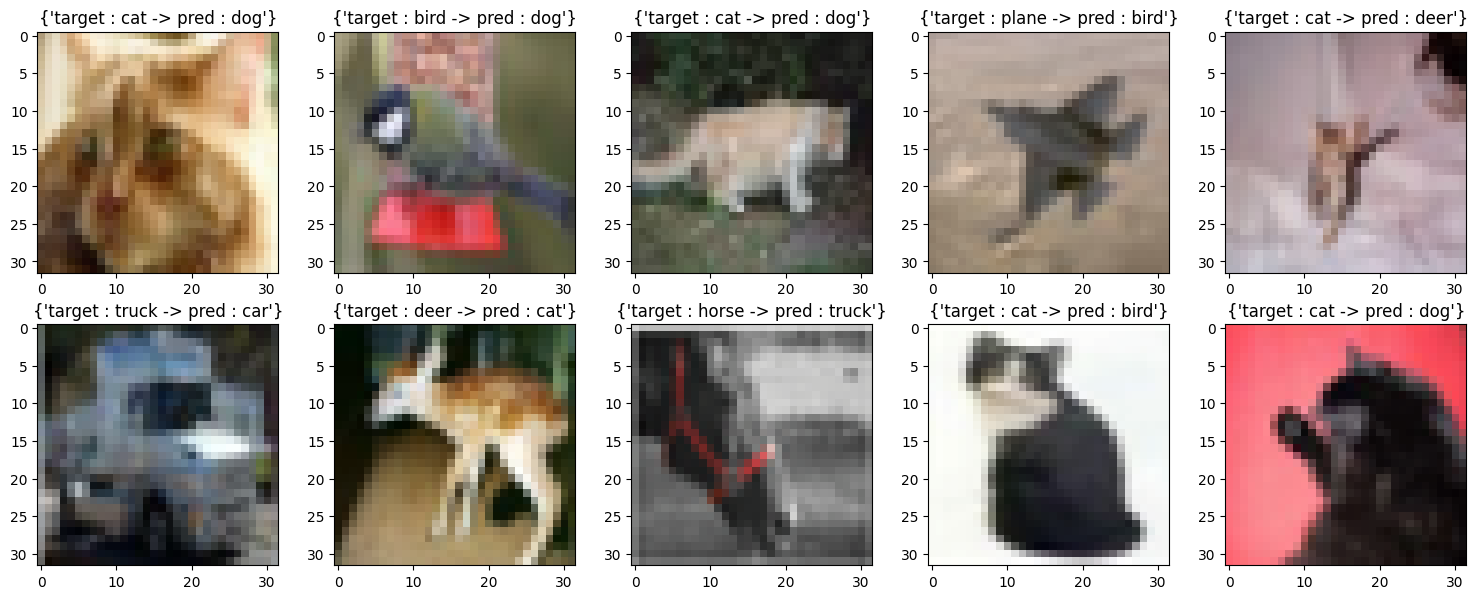

In [49]:
#collect misclassified images

wrongly_predicted_samples = test(model, device, test_loader)
samples = random.sample(range(0,wrongly_predicted_samples["image"].shape[0]), 10)
misclassified_images = wrongly_predicted_samples["image"][samples].cpu().numpy()
predictions = [classes[category] for category in wrongly_predicted_samples["pred"][samples].cpu().tolist()]
targets = [classes[category] for category in wrongly_predicted_samples["target"][samples].cpu().tolist()]

# functions to show an misclassified image with label
def imshow_misclassified(ax, img, pred, original):
    # unnormalize
    mean = np.array((0.4914, 0.4822, 0.4465))
    std = np.array((0.2023, 0.1994, 0.2010))
    img = img * std[:, None, None] + mean[:, None, None]
    ax.imshow(np.transpose(img, (1, 2, 0)))
    ax.set_title({"target : {} -> pred : {}".format(original, pred)})

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
# Display images
for ax, image, pred, target in zip(axes, misclassified_images, predictions, targets):
  imshow_misclassified(ax, image, pred, target)

plt.tight_layout()
plt.show()

In [50]:
model

Net(
  (convblock1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
  )
  (convblock2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
  )
  (convblock3): Sequential(
    (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convblock4): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
  )
  (convblock5): Se

Text(0.5, 1.0, 'Test Accuracy')

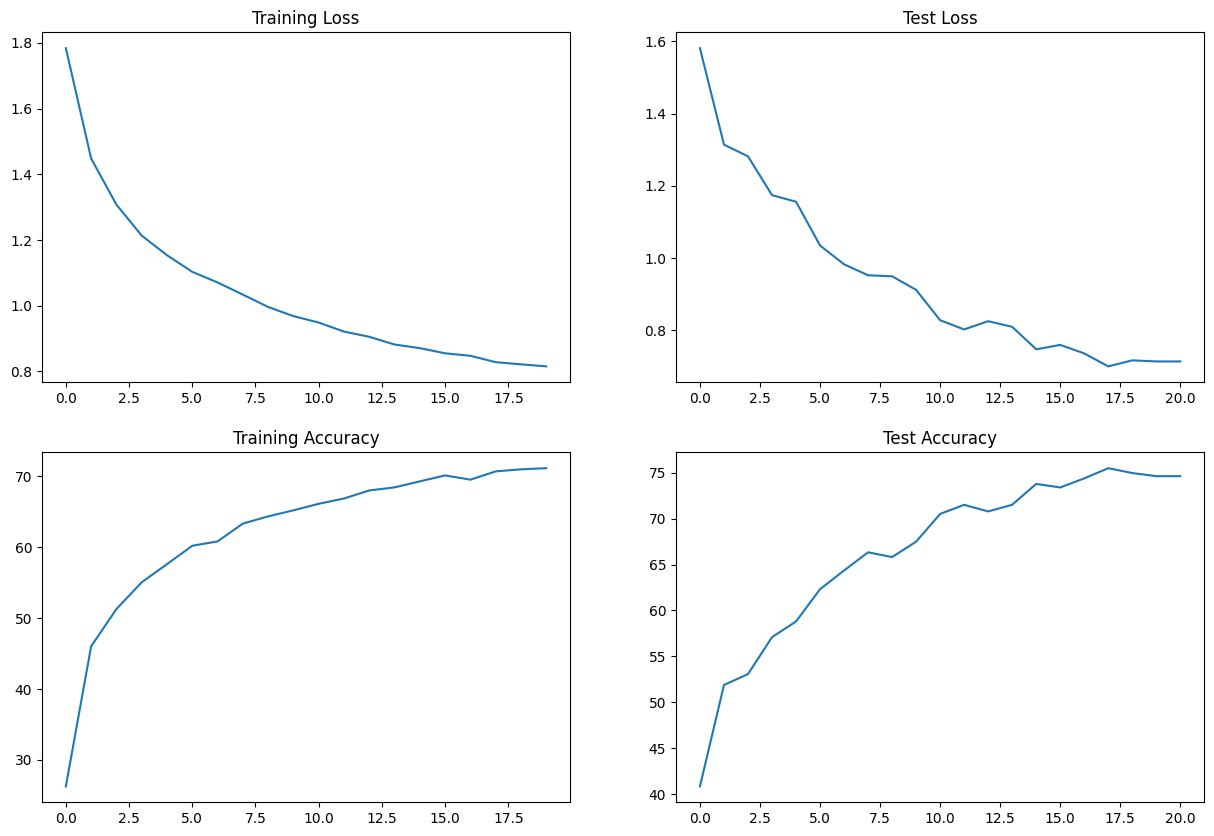

In [51]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot([float(loss.cpu()) for loss in train_loss_per_epoc])
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc_per_epoc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [12]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list

model_children = model.children()
for children in model_children:
    if type(children) == nn.Sequential:
        for child in children:
            if type(child) == nn.Conv2d:
                counter += 1
                model_weights.append(child.weight)
                conv_layers.append(child)

print(f"Total convolution layers: {counter}")
print("conv_layers")

Total convolution layers: 10
conv_layers


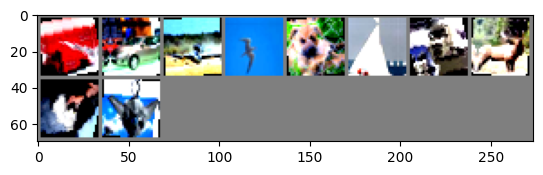

In [13]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:10]))

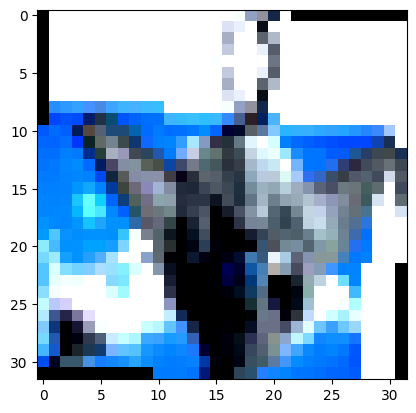

In [14]:
image = images[9]
imshow(image)

In [15]:
image = image.unsqueeze(0)
image = image.to(device)

In [16]:
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

10
torch.Size([1, 32, 32, 32])
torch.Size([1, 32, 32, 32])
torch.Size([1, 16, 32, 32])
torch.Size([1, 32, 32, 32])
torch.Size([1, 32, 32, 32])
torch.Size([1, 16, 32, 32])
torch.Size([1, 32, 32, 32])
torch.Size([1, 32, 30, 30])
torch.Size([1, 32, 28, 28])
torch.Size([1, 10, 28, 28])


In [17]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    # gray_scale = feature_map[0]
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(30, 30)
(28, 28)
(28, 28)


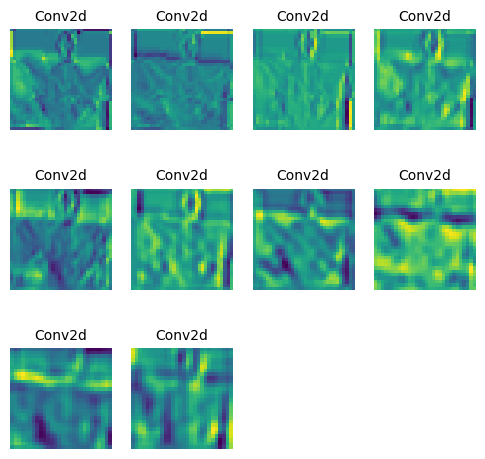

In [18]:
fig = plt.figure(figsize=(6, 10))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=10)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

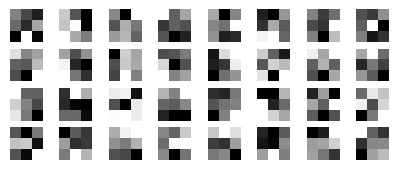

In [19]:
# visualize the first conv layer filters
plt.figure(figsize=(5, 4))
first_layer_weights = model_weights[0].cpu()
for i, filter in enumerate(first_layer_weights):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
plt.show()